In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
fs = pd.read_parquet(r"C:\Users\vnsp8460\Desktop\Johnny_folder\flash_sale\fts_choice_0428_0512.parquet")
choice_preds = pd.read_csv(r"C:\Users\vnsp8460\Desktop\Johnny_folder\flash_sale\choice_preds.csv")

In [102]:
# Add uplift score to fs
fs_merge = fs.merge(
    choice_preds, 
    on=[
    "item_id",
    "model_id",
    "item_name", 
    "item_price_before_discount_pp",
    "order_price_pp"
    ],
    how="inner") 

In [103]:
# Target column 
shifted = fs_merge[[ 
    'model_id', 
    'grass_date', 
    'item_amount'
    ]].copy()

shifted['grass_date'] = shifted['grass_date'] - np.timedelta64(2, 'D')
shifted = shifted.rename(columns={'item_amount': 'target'})

shifted = shifted.drop_duplicates(subset=['model_id', 'grass_date'])

fs_merge = fs_merge.merge(
    shifted,
    on=[ 
        'model_id',  
        'grass_date', 
        ],
        how='left')

In [104]:
# Test
#print(list(set(fs_merge["model_id"]))) # 185737183249
#fs_merge[fs_merge["model_id"] == 185737183249][[
#    "grass_date", "item_amount", "target", "uplift_score"
#]].sort_values(by="grass_date")

In [105]:
# Visualize data
#print(np.quantile(fs_merge["uplift_score"], [0,0.25,0.5,0.75,1]))
#sns.histplot(data=fs_merge, x="uplift_score", kde=True, color="red")

In [106]:
# Quartiles to remove outliers
quartiles = np.quantile(fs_merge["uplift_score"], [0,0.25,0.5,0.75,1])

q1 = np.quantile(fs_merge["uplift_score"], 0.25)
q3 = np.quantile(fs_merge["uplift_score"], 0.75)
iqr = q3 - q1

#lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

lower_bound = np.quantile(fs_merge["uplift_score"], 0.05)
upper_bound = np.quantile(fs_merge["uplift_score"], 0.95)

quartiles

array([-6.27612096e+01, -1.28413885e-02,  2.63092784e-01,  6.73250035e-01,
        3.49712685e+02])

In [107]:
# Remove outliers
fs_no_outliers = fs_merge[
    (fs_merge["uplift_score"] > lower_bound) &
    (fs_merge["uplift_score"] < upper_bound)
    ].copy()

fs_no_outliers["order_price_pp"] = fs_no_outliers["order_price_pp"].astype(float)
fs_no_outliers["item_price_before_discount_pp"] = fs_no_outliers["item_price_before_discount_pp"].astype(float)

<Axes: xlabel='uplift_score', ylabel='Count'>

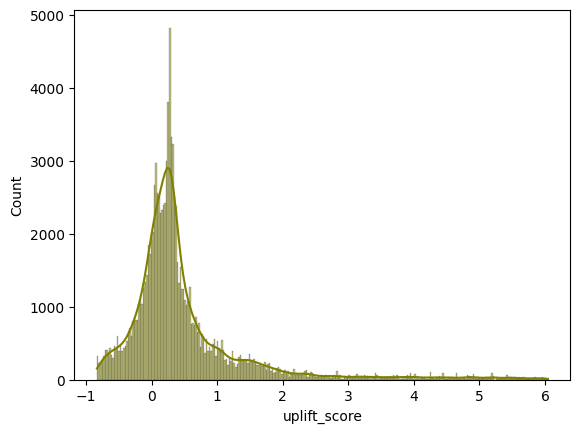

In [108]:
# Visualize data without outliers 
sns.histplot(data=fs_no_outliers, x="uplift_score", kde=True, color="olive")

In [ ]:
# Establish quartiles for filtered dataset
new_q1 = np.quantile(fs_no_outliers["uplift_score"], 0.25)
new_median = np.quantile(fs_no_outliers["uplift_score"], 0.5)
new_q3 = np.quantile(fs_no_outliers["uplift_score"], 0.75)

new_quartiles = np.quantile(fs_no_outliers["uplift_score"], [0, 0.25, 0.5, 0.75, 1])
new_quartiles

array([-0.83698872,  0.02412334,  0.26318953,  0.58402259,  6.04364177])

In [111]:
# Define performance 
fs_no_outliers = fs_no_outliers.copy()
def performance(item_uplift, arg1, arg2):
    if item_uplift > arg2:
        return "high-performer"
    elif item_uplift < arg1:
        return "low-performer"
    else:
        return "mid-performer"

arg1 = new_q1
arg2 = new_q3
#arg2 = 1

fs_no_outliers["performance"] = fs_no_outliers["uplift_score"].apply(performance, args=(arg1,arg2)) 

<Axes: xlabel='uplift_score', ylabel='Count'>

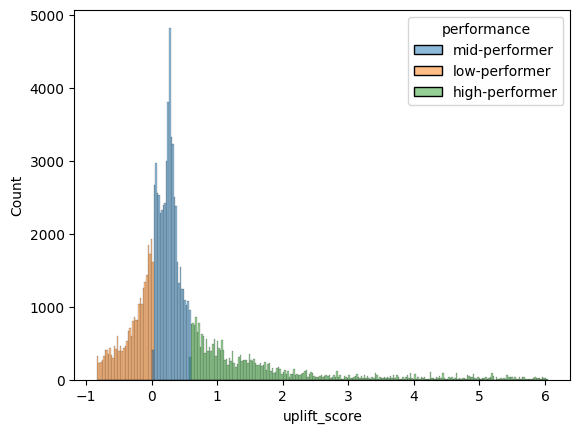

In [112]:
sns.histplot(
    data=fs_no_outliers, 
    x="uplift_score", 
    hue="performance"
    )

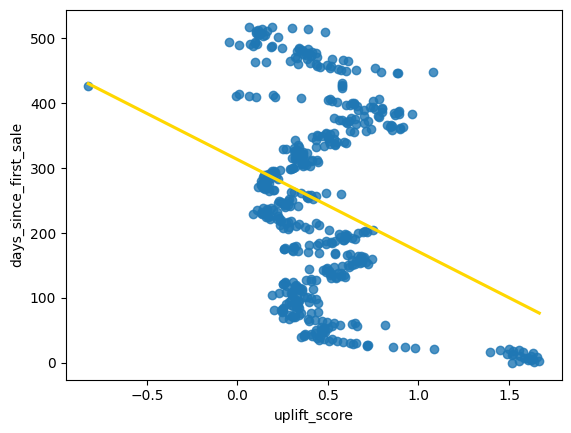

In [113]:
# Test visualization 
# days_since_first_sale_data = pd.DataFrame(fs_no_outliers.groupby('days_since_first_sale')['uplift_score'].median()).reset_index()
days_since_first_sale_data = pd.DataFrame(fs_no_outliers.groupby('days_since_first_sale')['uplift_score'].mean()).reset_index()

sns.regplot(
    data=days_since_first_sale_data, 
    y="days_since_first_sale", 
    x="uplift_score", 
    ci=None, 
    line_kws={'color':'gold'}
    )
plt.show()

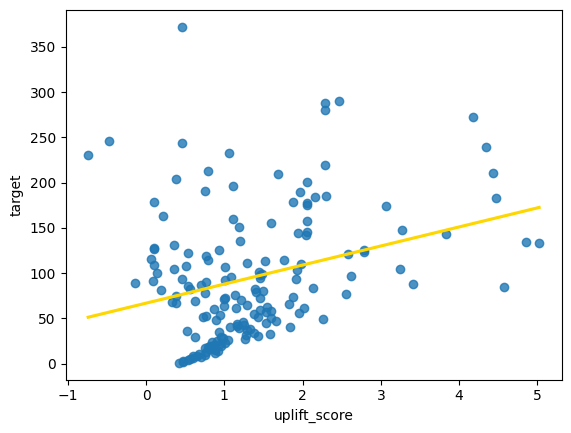

0.3020755543128848 indicates a positive linear relationship between target and uplift


In [114]:
# Target column visualization
# target_data = pd.DataFrame(fs_no_outliers.groupby('target')['uplift_score'].median()).reset_index()
target_data = pd.DataFrame(fs_no_outliers.groupby('target')['uplift_score'].mean()).reset_index()

sns.regplot(
    data=target_data,
    y="target",
    x="uplift_score",
    ci=None, 
    line_kws={'color':'gold'}
)
plt.show()

correlation = target_data[['uplift_score', 'target']].corr().iloc[0,1]
print(f"{correlation} indicates a positive linear relationship between target and uplift")

In [100]:
# Uplift amount set-up
#temp = fs_no_outliers[[
#    'model_id', 
#    'grass_date',
#    'order_price_pp', 
#    'item_price_before_discount_pp', 
#    'item_amount', 
#    'treatment', 
#    'uplift_score'
#    ]].copy()

# temp1 = temp.groupby('model_id').filter(lambda t: set(t['treatment'].unique()) >= {'treatment','control'})

#temp2 = temp.groupby([
#    'model_id',
#    #'order_price_pp',
#    'item_price_before_discount_pp',
#    'treatment'
#    ])['item_amount'].mean().unstack().reset_index()

#temp3 = temp.groupby([
#    'model_id',
#    #'order_price_pp',
#   'item_price_before_discount_pp'
#    ])['uplift_score'].mean().reset_index()

#temp2

In [ ]:
# Create uplift amount in temp2
#temp2['uplift_amount'] = temp2['treatment']-temp2['control']
#temp2 = temp2[temp2['uplift_amount'].isna() == False]

# Merge with temp3 to add uplift score
#item_amount_uplift = temp2.merge(
#    temp3, 
#    on=['model_id','item_price_before_discount_pp'],
#    how='inner'
#    ).copy()

In [99]:
# Visualize item_amount_uplift
#sns.regplot(
#    data=item_amount_uplift,
#    x='uplift_score',
#    y='uplift_amount',
#    ci=None, 
#    line_kws={'color':'gold'}
#)

In [98]:
# Remove noise in visualization by creating bins
#item_amount_uplift['bin'] = pd.qcut(item_amount_uplift['uplift_amount'],q=500,duplicates='drop')
#item_amount_uplift['uplift_amount'] = item_amount_uplift['bin'].apply(lambda x: x.mid)

#item_amount_uplift_data = item_amount_uplift.groupby('uplift_amount', observed=True)['uplift_score'].mean().reset_index()

#sns.regplot(
#    data=item_amount_uplift_data,
#    x='uplift_score',
#    y='uplift_amount',
#    ci=None, 
#    line_kws={'color':'gold'}
#)
#plt.show()

<Axes: xlabel='uplift_score', ylabel='total_pdp_view_cnt'>

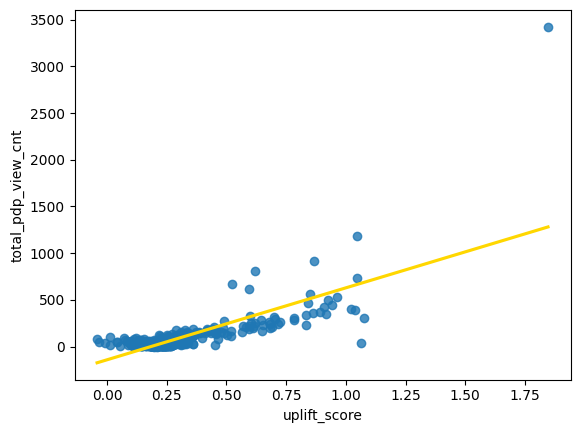

In [115]:
# Uplift score and total product view count
temp = fs_no_outliers.copy()
temp['bin'] = pd.qcut(temp['total_pdp_view_cnt_model'],q=500,duplicates='drop')
temp['total_pdp_view_cnt'] = temp['bin'].apply(lambda x: x.mid)

pdp_view_data = temp.groupby('total_pdp_view_cnt', observed=True)['uplift_score'].median().reset_index()

sns.regplot(data=pdp_view_data, y='total_pdp_view_cnt', x='uplift_score', ci=None, line_kws={'color':'gold'})

In [116]:
def summarize_category(x):
    count = []
    count = pd.DataFrame(fs_no_outliers.groupby(x)[x].count())
    count.rename(columns={x:"total_count"}, inplace=True)

    fs_filtered = fs_no_outliers[fs_no_outliers["performance"]=="high-performer"]

    high_count = []
    high_count = pd.DataFrame(fs_filtered.groupby(x)[x].count())
    high_count.rename(columns={x:"high_count"}, inplace=True)

    uplift_mean = []
    uplift_mean = pd.DataFrame(fs_no_outliers.groupby(x)["uplift_score"].mean())
    uplift_mean.rename(columns={"uplift_score":"avg_uplift"}, inplace=True)

    high_count = high_count.merge(
    count,
    on=x,
    how="inner"
    )

    high_count = high_count.merge(
    uplift_mean,
    on=x,
    how="inner"
    )

    category_summary = high_count.copy()
    category_summary["high/total"] = category_summary["high_count"]/category_summary["total_count"]

    return category_summary.sort_values(by="avg_uplift",ascending=False)

# summarize_category("level1_global_be_category").tail(5)

In [117]:
category = [
    "level1_global_be_category", 
    "level2_global_be_category",
    "treatment",
    "fs_display_category"
    ]

summarize_category("level1_global_be_category")

,high_count,total_count,avg_uplift,high/total
level1_global_be_category,,,,
Gaming & Consoles,20,20,3.799878,1.000000
Automobiles,262,446,1.346158,0.587444
Cameras & Drones,24,34,1.114046,0.705882
Fashion Accessories,1020,2707,0.844296,0.376801
Home & Living,10745,28124,0.739657,0.382058
Hobbies & Collections,192,578,0.689501,0.332180
Mobile & Gadgets,980,2495,0.671773,0.392786
Home Appliances,486,1145,0.652981,0.424454
Health,1365,4597,0.550997,0.296933
